In [ ]:
# Make a nice documentation to this program

In [1]:
import math
import pymrmr
import matplotlib
import numpy as np
import pandas as pd
from math import ceil
import random as rand
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn import preprocessing
from collections import defaultdict
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import VarianceThreshold

plt.rcParams["font.family"] = "Charter"
plt.style.use('seaborn-deep')

# https://pypi.org/project/pymrmr/
# source: https://github.com/StatQuest/pca_demo/blob/master/pca_demo.py
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

In [2]:
# load the corresponding assay into RAM

# declare the filename
file='../../02-CorrectingAssays/_output/cp_1030.csv'
# read the file and define the Inputs (X) and targets (y)
df=pd.read_csv(file)
X = df.iloc[:,10:]
y = df.PUBCHEM_ACTIVITY_OUTCOME

In [14]:
# Apply PCA

# data needs to be scaled via Z-Score, which is pretty much the default
scaled_data = preprocessing.scale(X)
# instantiate PCA() object
pca = PCA()
# fit the PCS to the scaled data (here happens the maths)
pca.fit(scaled_data)
# project the data onto the principal components and therefore obtain new values for every compound
pca_data = pca.transform(scaled_data) # get PCA coordinates for scaled_data

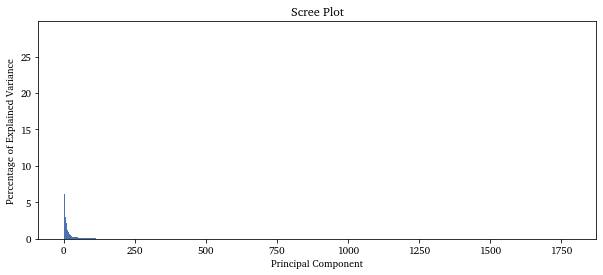

In [15]:
# make a plot of the explained variance for every principal component

# explained variane in percent for every principal component
pca_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)

# plot the variance as a bar plot
plt.figure(num=4,figsize=[10,4])
plt.bar(x=range(1,len(pca_var)+1), height=pca_var, width=1)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.savefig("../_output/pca_rf_cp_1030_screeplot.svg", dpi=300)
plt.show()

In [16]:
# calculate how many PCs are needed to account for >90 percent of the variance

# declare the sum over all variances of the principal components
sum_var = 0

# loop over all principal component
for i in range(len(pca.explained_variance_ratio_)):
    # add the explained variance of the i-th principal component to the sum
    sum_var = sum_var+pca.explained_variance_ratio_[i]
    
    # if the sum accounts for 90 percent of the principal components stop the loop
    if sum_var > 0.9:
        break

57 Principal Components account for
90.0% of the Variance.


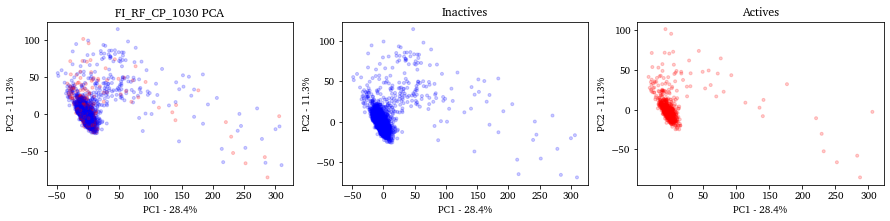

In [18]:
### Plot the data of the first two principal components for every compound and for actives and inactives only

# list of names of the individual PCs is declared for introduction of a pd-dataframe (easier data handling)
labels = ['PC' + str(x) for x in range(1, len(pca_var)+1)]

# initiate a pd dataframe that holds the PCA data and the labels
pca_df = pd.DataFrame(pca_data, columns=labels)

# to color code the results by target classes define the target list as an ordered list of actives and inactives
target = (y == 'Active').astype('int').to_list()
actives = (y == 'Active').astype('int')[(y == 'Active')]
inactives = (y != 'Active').astype('int')[(y != 'Active')]

# use the colors red and blue, for inactives only blue and for actives only red
colors = matplotlib.colors.ListedColormap(['blue','red'])
colors0 = matplotlib.colors.ListedColormap(['blue'])
colors1 = matplotlib.colors.ListedColormap(['red'])

# define the x and y values for plotting the actives and inactives only
# just calling the pandas series did not work, therefore the np array is called using .values 
pc1_actives = pca_df[(y == 'Active')].PC1.values
pc2_actives = pca_df[(y == 'Active')].PC2.values
pc1_inactives = pca_df[(y != 'Active')].PC1.values
pc2_inactives = pca_df[(y != 'Active')].PC2.values

# instantiate subplots object with 1 row 3 columns and given figure size
fig, (ax3,ax1,ax2) = plt.subplots(1,3, figsize=(15,3),num=0)

# define the scatter plots of all compounds and of only the actives and inactives separately
ax3.scatter(pca_df.PC1, pca_df.PC2, c=target, cmap=colors, marker='.',alpha=0.2)
ax1.scatter(pc1_inactives,pc2_inactives,c=inactives, cmap=colors0, marker='.',alpha=0.2)
ax2.scatter(pc1_actives,pc2_actives,c=actives, cmap=colors1, marker='.',alpha=0.2)

# set all the titles
ax3.set_title('FI_RF_CP_1030 PCA')
ax1.set_title('Inactives')
ax2.set_title('Actives')

# set axis labels
ax3.set_xlabel('PC1 - {0}%'.format(pca_var[0]))
ax1.set_xlabel('PC1 - {0}%'.format(pca_var[0]))
ax2.set_xlabel('PC1 - {0}%'.format(pca_var[0]))
ax3.set_ylabel('PC2 - {0}%'.format(pca_var[1]))
ax1.set_ylabel('PC2 - {0}%'.format(pca_var[1]))
ax2.set_ylabel('PC2 - {0}%'.format(pca_var[1]))

# export and show
plt.savefig("../_output/pca_rf_cp_1030_pca_data.svg", dpi=300)
plt.show()

In [19]:
### find the original features that originally most contributed to the variance within the first principal component

# maka a pd series and index it with the corresponding feature names
pc1_scores = pd.Series(pca.components_[0], index=X.columns)
# now sort the loading scores based on their absolute values
sorted_pc1_scores = pc1_scores.abs().sort_values(ascending=False)
# get the indexes aka the names of the top 10 features
top_100 = sorted_pc1_scores[0:100].index.values

Cells_Texture_Contrast_ER_5_0                     0.041862
Cytoplasm_Texture_Contrast_ER_5_0                 0.041577
Cells_Texture_Contrast_ER_3_0                     0.041358
Cytoplasm_Texture_DifferenceVariance_ER_3_0       0.041279
Cells_Texture_Contrast_RNA_10_0                   0.041251
                                                    ...   
Cytoplasm_Texture_Contrast_DNA_10_0               0.038297
Cells_Intensity_MeanIntensity_ER                  0.038273
Cells_Intensity_MADIntensity_AGP                  0.038268
Cytoplasm_RadialDistribution_RadialCV_DNA_2of4    0.038259
Cytoplasm_Texture_Entropy_DNA_3_0                 0.038219
Length: 100, dtype: float64


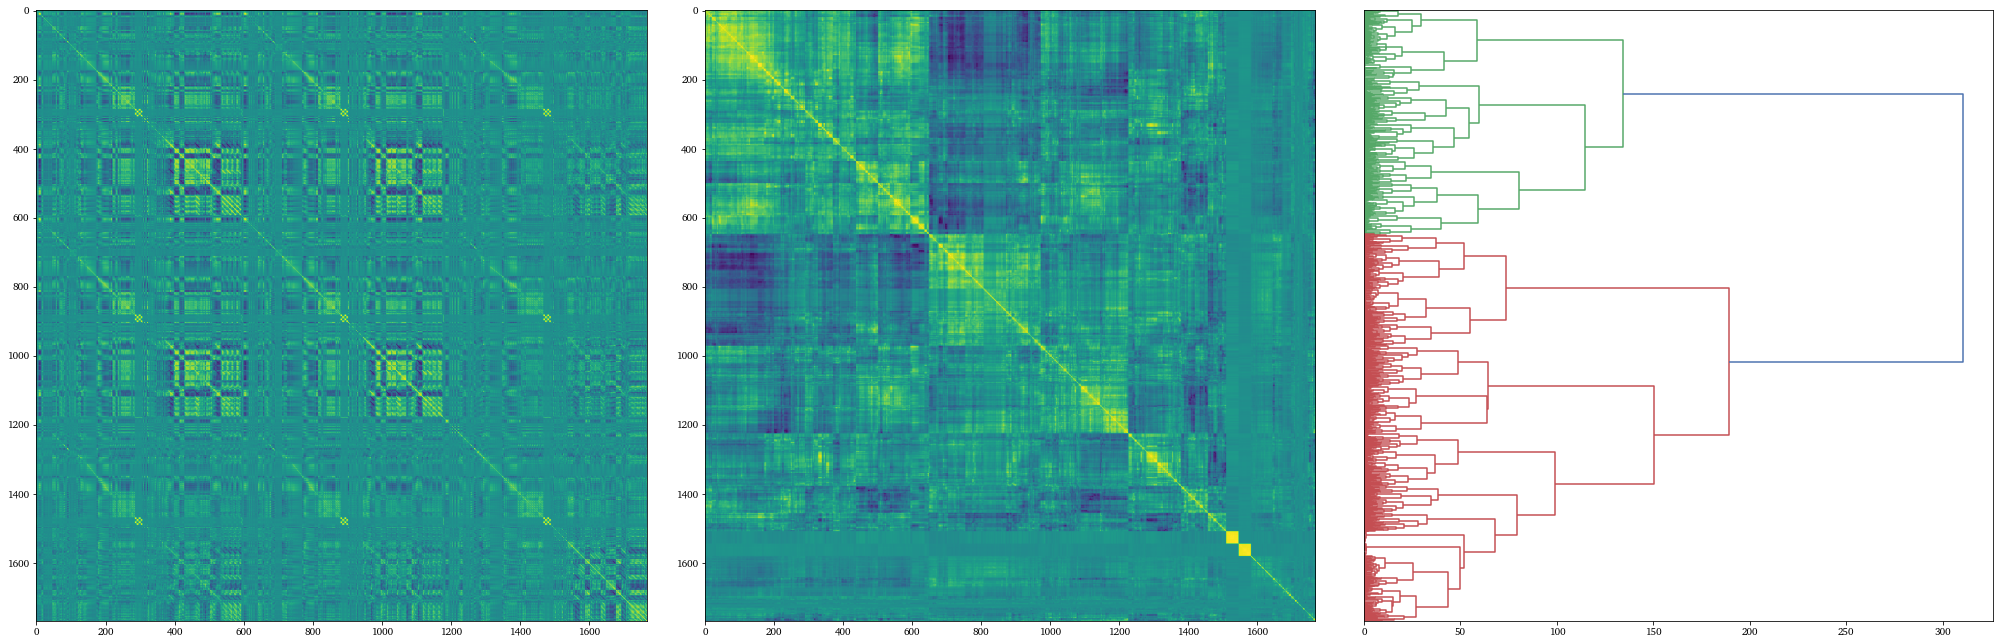

In [3]:
# removing zero variance features from the Dataset X
selector = VarianceThreshold()
X_var0 = selector.fit_transform(X)
ids = selector.get_support(indices=True).tolist()
X_var0 = pd.DataFrame(X_var0, columns=X.columns[ids])


# define subplots for plotting the dendrogram and the Correlation Matrix
fig, (ax3, ax2, ax1) = plt.subplots(1, 3, figsize=(28, 9),num=3)

# calculate the correlation matrix
corr = spearmanr(X_var0).correlation

# calculate the linkage for the dendrogram (hierarchical clustering using the Ward's method)
corr_linkage = hierarchy.ward(corr)

# instantiate the dendrogram from the corr_linkage array (holding the distances) and plot it on ax1
dendro = hierarchy.dendrogram(corr_linkage, no_labels=True, ax=ax1, leaf_rotation=90, orientation='right')
ax1.invert_yaxis()

# plot a heatmap of clustered correlation matrix
ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])

# plot a heat map of the unclustered correlation matrix
ax3.imshow(corr)

# make the subplots fit into the figure size and show the plots
fig.tight_layout()
plt.savefig("../_output/spearman_cluster_rf_cp_1030.svg", dpi=300)
plt.show()

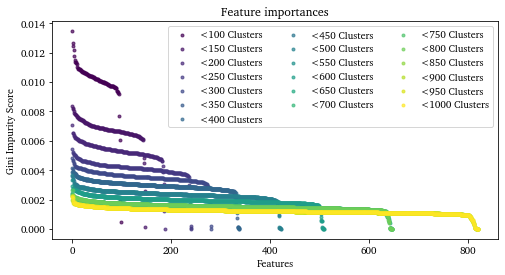

In [22]:
### feature selection with hierarchical clustering depends on how many features 

# instantiate figure object
plt.figure(num=1,figsize=[8,4])
# give it a title
plt.title("Feature importances")

# define legend list for holding the individual labels
legendlist = []

# a for loop will cycle through different numbers of clusters to be included into the RF feature importance
# this specifies the arguments of the range function
upper=1050
under=100
step=50

# for using the viridis colormap for every iteration the iterables need to be normalized with respect to 
# the highest and lowest value
norm = matplotlib.colors.Normalize(under,upper-step)
cmap = matplotlib.cm.get_cmap('viridis')

# iterate through the range of clusters to include
for sel_goal in range(under,upper,step):
    # maximal distance that is sampled during hierarchical clustering
    max_dist = corr_linkage[-1,2]

    # loop over the integers (cutoff distances) til max_dist is reached
    for cutoff in range(math.ceil(max_dist)):
        # use fcluster to get a flat cluster with cutoff and save the indexes
        cluster_ids = hierarchy.fcluster(corr_linkage, cutoff, criterion='distance')
        # if the number of unique indexes (features) is smaller than half the total number of features:
        if len(np.unique(cluster_ids)) < sel_goal:
            # define t as the current cutoff
            t = cutoff
            # stop the for loop
            break

    # fcluster returns the cluster indices, that belong to the feature at position i in the cluster_ids list
    cluster_ids = hierarchy.fcluster(corr_linkage, t=t, criterion='distance')

    # a dictionary is defined, where the cluster ids are paired up with the features in that cluster
    cluster_id_to_feature_ids = defaultdict(list)

    # enumerating through cluster ids gives the idx (of the feature) and the cluster id of the hierarchical clustering
    for idx, cluster_id in enumerate(cluster_ids):
        # append the feature index to the cluster id entry within the dict
        cluster_id_to_feature_ids[cluster_id].append(idx)

    # get the selected features by iterating through the dict and randomly choose one of the clustered features
    selected_features = [v[rand.randint(0,len(v)-1)] for v in cluster_id_to_feature_ids.values()]

    #update the data frame
    X_sel = X_var0.loc[:,X_var0.columns[selected_features]]

    # Build a forest and compute the impurity-based feature importances

    # instantiate the forest model
    forest = ExtraTreesClassifier(n_estimators=250,
                                  random_state=0)

    # fit the model to the inputs and targets
    forest.fit(X_sel, y)
    # initialize the importances of each individual feature
    importances = forest.feature_importances_
    # report the standard deviation of all importance scores
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

    # get the indiced in order of highest importance
    indices = np.argsort(importances)[::-1]
    # get the features in order of highest importance
    sorted_features = X_sel.columns[np.argsort(importances)[::-1]]

    # Plot the impurity-based feature importances of the forest and use the viridis color map for it
    plt.scatter(range(X_sel.shape[1]), importances[indices],color=cmap(norm(sel_goal)), marker='.',alpha=0.7)
    # append the number of clusters (from which random features are chosen above) to the legend
    legendlist.append("<"+str(sel_goal)+" Clusters")

# plotting metrics
plt.legend(legendlist,ncol=3)
plt.xlabel("Features")
plt.ylabel("Gini Impurity Score")
plt.savefig("../_output/gi_rf_cp_1030_variableClusterNumber.svg", dpi=300)
plt.show()

In [23]:
# maximal distance that is sampled during hierarchical clustering
max_dist = corr_linkage[-1,2]

# loop over the integers (cutoff distances) til max_dist is reached
for cutoff in range(math.ceil(max_dist)):
    # use fcluster to get a flat cluster with cutoff and save the indexes
    cluster_ids = hierarchy.fcluster(corr_linkage, cutoff, criterion='distance')
    # if the number of unique indexes (features) is smaller than half the total number of features:
    if len(np.unique(cluster_ids)) < 400:
        # define t as the current cutoff
        t = cutoff
        # stop the for loop
        break

# fcluster returns the cluster indices, that belong to the feature at position i in the cluster_ids list
cluster_ids = hierarchy.fcluster(corr_linkage, t=t, criterion='distance')

# a dictionary is defined, where the cluster ids are paired up with the features in that cluster
cluster_id_to_feature_ids = defaultdict(list)

# enumerating through cluster ids gives the idx (of the feature) and the cluster id of the hierarchical clustering
for idx, cluster_id in enumerate(cluster_ids):
    # append the feature index to the cluster id entry within the dict
    cluster_id_to_feature_ids[cluster_id].append(idx)

# get the selected features by iterating through the dict and randomly choose one of the clustered features
selected_features = [v[rand.randint(0,len(v)-1)] for v in cluster_id_to_feature_ids.values()]

#update the data frame
X_sel = X_var0.loc[:,X_var0.columns[selected_features]]

In [24]:
# Build a forest and compute the impurity-based feature importances

# instantiate the forest model
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

# fit the model to the inputs and targets
forest.fit(X_sel, y)
# initialize the importances of each individual feature
importances = forest.feature_importances_
# report the standard deviation of all importance scores
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# get the indiced in order of highest importance
indices = np.argsort(importances)[::-1]
# get the features in order of highest importance
sorted_features = X_sel.columns[np.argsort(importances)[::-1]]

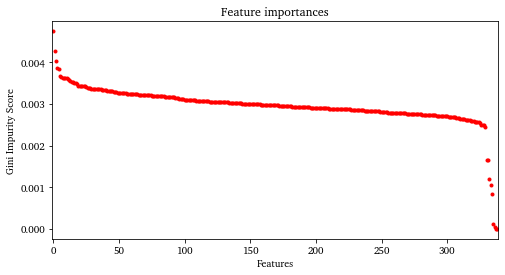

In [25]:
# Plot the impurity-based feature importances of the forest
plt.figure(num=2,figsize=[8,4])
plt.title("Feature importances")
plt.scatter(range(X_sel.shape[1]), importances[indices],
        color="r", marker='.')
plt.xlabel("Features")
plt.ylabel("Gini Impurity Score")
plt.xlim([-1, X_sel.shape[1]])
plt.savefig("../_output/gi_rf_cp_1030_400Clusters.svg", dpi=300)
plt.show()

In [26]:
# Print the feature ranking

# create a pandas dataframe with all relevant information about the Gini impurity based feature importance
gi_fi = pd.DataFrame(columns=['Ranking','Feature','Score','StdDev'], index=range(len(importances)))
gi_fi['Ranking'] = range(1,len(importances)+1)
gi_fi['Feature'] = sorted_features
gi_fi['Score'] = importances[indices]
gi_fi['StdDev'] = std[indices]

In [27]:
# Write the numbers of PCs that is needed to account for 90% Variance in this dataset
f = open("../_output/pca_rf_cp_1030_info.txt","w+")
f.write("{} Principal Components account for\n{}% of the Variance.".format(i,np.round(sum_var*100,decimals=1)))
f.close() 

# export the PCA transformed data into a csv file
df_pca = pd.DataFrame(data=pca_data, columns=labels)
df_pca = pd.concat([df.iloc[:,:10], df_pca],axis=1)
df_pca.to_csv("../_output/pca_rf_cp_1030_data.csv",index=False)

# write the 100 most contributing features of PC1 to text file
pc1_scores[top_100].to_csv("../_output/pca_rf_cp_1030_top100.txt",header=False)

# Gini impurity based feature importance is exported along with standard deviation and the feature names
gi_fi.to_csv('../_output/gi_rf_cp_1030.csv',index=False)

In [ ]:
# make list of columns that are relevant to MRMR
mrmr_cols = df.columns[10:]
# insert the binary column name for the target vector into the list
mrmr_cols = mrmr_cols.insert(0, 'PUBCHEM_ACTIVITY_OUTCOME_bin')
# create the column with the binary target vector
df['PUBCHEM_ACTIVITY_OUTCOME_bin'] = (df['PUBCHEM_ACTIVITY_OUTCOME']=='Active').astype('int')
# calculate MRMR
mrmr_top100 = pymrmr.mRMR(df[mrmr_cols], 'MIQ', 30)

# Write the top100 features from MRMR analysis into a text file
with open('../_output/mrmr_rf_cp_1030_top30.txt', 'w') as file:
    for item in mrmr_top100:
        file.write("%s\n" % item)